# Transmittance Spectra for Planewave at Normal Incidence of a Binary Grating

The mode-decomposition feature can also be applied to planewaves in homogeneous media with scalar permittivity/permeability (i.e., no anisotropy). This will be demonstrated in this example to compute the diffraction spectrum of a binary phase [grating](https://en.wikipedia.org/wiki/Diffraction_grating). To compute the diffraction spectrum for a finite-length structure, see [Tutorials/Near to Far Field Spectra/Diffraction Spectrum of a Finite Binary Grating](https://meep.readthedocs.io/en/latest/Python_Tutorials/Near_to_Far_Field_Spectra/#diffraction-spectrum-of-a-finite-binary-grating). 

In this example, we'll define a grating that is periodic in the $y$ direction with periodicity `gp` and has a rectangular profile of height `gh` and duty cycle `gdc`. The grating parameters are `gh`=0.5 μm, `gdc`=0.5, and `gp`=10 μm. There is a semi-infinite substrate of thickness `dsub` adjacent to the grating. The substrate and grating are glass with a refractive index of 1.5. The surrounding is air/vacuum. Perfectly matched layers (PML) of thickness `dpml` are used in the $\pm x$ boundaries.

We'll do our analysis first using an ideal quartz that ignores the dispersion of the material. Then we'll include the dispersion to detect any differences.

A pulsed planewave with $E_z$ polarization spanning wavelengths of 0.4 to 0.6 μm is normally incident on the grating from the glass substrate. The eigenmode monitor is placed in the air region. We will use mode decomposition to compute the transmittance — the ratio of the power in the $+x$ direction of the diffracted mode relative to that of the incident planewave — for the first ten diffraction orders. 

Two simulations are required: (1) an empty cell of homogeneous glass to obtain the incident power of the source, and (2) the grating structure to obtain the diffraction orders. At the end of the simulation, the wavelength, angle, and transmittance for each diffraction order are computed.

Initially, we'll import our standard libraries:

In [1]:
import meep as mp
import math
import numpy as np
import matplotlib.pyplot as plt

Using MPI version 3.1, 1 processes


We first need to simulate the empty, homogenous glass (fuzed quartz) with a constant refractive index.

-----------
Initializing structure...


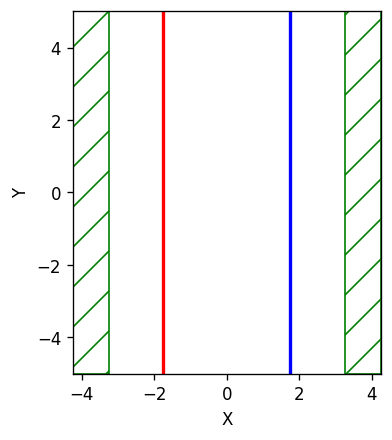

In [2]:
fused_quartz = mp.Medium(index=1.5)

resolution = 50  # pixels/μm

dpml = 1.0  # PML thickness
dsub = 3.0  # substrate thickness
dpad = 3.0  # padding between grating and PML
gp = 10.0  # grating period
gh = 0.5  # grating height
gdc = 0.5  # grating duty cycle

sx = dpml + dsub + gh + dpad + dpml
sy = gp

cell_size = mp.Vector3(sx, sy, 0)
pml_layers = [mp.PML(thickness=dpml, direction=mp.X)]

wvl_min = 0.4  # min wavelength
wvl_max = 0.6  # max wavelength
fmin = 1 / wvl_max  # min frequency
fmax = 1 / wvl_min  # max frequency
fcen = 0.5 * (fmin + fmax)  # center frequency
df = fmax - fmin  # frequency width

src_pt = mp.Vector3(-0.5 * sx + dpml + 0.5 * dsub)
sources = [
    mp.Source(
        mp.GaussianSource(fcen, fwidth=df),
        component=mp.Ez,
        center=src_pt,
        size=mp.Vector3(y=sy),
    )
]

k_point = mp.Vector3(0, 0, 0)

symmetries = [mp.Mirror(mp.Y)]

sim = mp.Simulation(
    resolution=resolution,
    cell_size=cell_size,
    boundary_layers=pml_layers,
    k_point=k_point,
    default_material=fused_quartz,
    sources=sources,
    symmetries=symmetries,
)

nfreq = 21
mon_pt = mp.Vector3(0.5 * sx - dpml - 0.5 * dpad)
flux_mon = sim.add_flux(
    fcen, df, nfreq, mp.FluxRegion(center=mon_pt, size=mp.Vector3(y=sy))
)

f = plt.figure(dpi=120)
sim.plot2D(ax=f.gca())
plt.show()

Now, we'll run the simulation and record the fields.

In [3]:
sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mon_pt, 1e-9))

field decay(t = 50.01): 0.10609306658233127 / 0.10609306658233127 = 1.0
field decay(t = 100.01): 8.493199823356459e-20 / 0.10609306658233127 = 8.005424008330923e-19
run 0 finished at t = 100.01 (10001 timesteps)


In [4]:
input_flux = mp.get_fluxes(flux_mon)

Next, we'll simulate the actual grating.

-----------
Initializing structure...
     block, center = (-2.25,0,0)
          size (4,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,0)
          size (0.5,5,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)


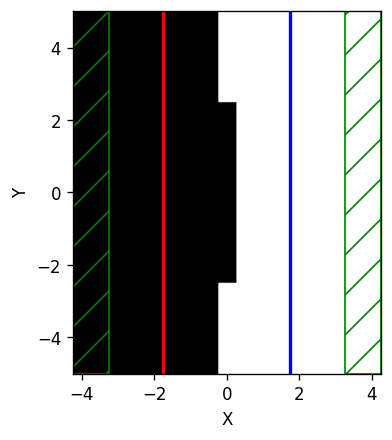

In [5]:
sim.reset_meep()

geometry = [
    mp.Block(
        material=fused_quartz,
        size=mp.Vector3(dpml + dsub, mp.inf, mp.inf),
        center=mp.Vector3(-0.5 * sx + 0.5 * (dpml + dsub)),
    ),
    mp.Block(
        material=fused_quartz,
        size=mp.Vector3(gh, gdc * gp, mp.inf),
        center=mp.Vector3(-0.5 * sx + dpml + dsub + 0.5 * gh),
    ),
]

sim = mp.Simulation(
    resolution=resolution,
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    k_point=k_point,
    sources=sources,
    symmetries=symmetries,
)

mode_mon = sim.add_flux(
    fcen, df, nfreq, mp.FluxRegion(center=mon_pt, size=mp.Vector3(y=sy))
)

f2 = plt.figure(dpi=120)
sim.plot2D(ax=f2.gca())
plt.show()

In [6]:
sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mon_pt, 1e-9))

field decay(t = 50.01): 0.1031398354415896 / 0.1031398354415896 = 1.0
field decay(t = 100.01): 8.275841626038753e-06 / 0.1031398354415896 = 8.023904237006029e-05
field decay(t = 150.02): 7.578862246277466e-06 / 0.1031398354415896 = 7.348142658778572e-05
field decay(t = 200.03): 2.633198313201328e-06 / 0.1031398354415896 = 2.5530371479917354e-05
field decay(t = 250.04): 1.0595609940381944e-06 / 0.1031398354415896 = 1.0273052981922272e-05
field decay(t = 300.04): 4.182093600425728e-07 / 0.1031398354415896 = 4.054780175399971e-06
field decay(t = 350.05): 1.7897453529966721e-07 / 0.1031398354415896 = 1.7352610127153491e-06
field decay(t = 400.06): 7.323581231104047e-08 / 0.1031398354415896 = 7.100633038387535e-07
field decay(t = 450.07): 2.934107857572782e-08 / 0.1031398354415896 = 2.844786250637789e-07
field decay(t = 500.08): 1.1841535133169714e-08 / 0.1031398354415896 = 1.1481049084934639e-07
field decay(t = 550.08): 4.9984066703627664e-09 / 0.1031398354415896 = 4.8462426267816536e-08
f

Now we can compute the diffraction orders as a function of wavelength:

In [7]:
freqs = mp.get_eigenmode_freqs(mode_mon)

nmode = 10
res = sim.get_eigenmode_coefficients(
    mode_mon, range(1, nmode + 1), eig_parity=mp.ODD_Z + mp.EVEN_Y
)
coeffs = res.alpha
kdom = res.kdom

mode_wvl = []
mode_angle = []
mode_tran = []

for nm in range(nmode):
    for nf in range(nfreq):
        mode_wvl.append(1 / freqs[nf])
        mode_angle.append(math.degrees(math.acos(kdom[nm * nfreq + nf].x / freqs[nf])))
        tran = abs(coeffs[nm, nf, 0]) ** 2 / input_flux[nf]
        mode_tran.append(0.5 * tran if nm != 0 else tran)

tran_max = round(max(mode_tran), 1)

Note the use of the keyword parameter argument `eig_parity=mp.ODD_Z+mp.EVEN_Y` in the call to `get_eigenmode_coefficients`. This is important for specifying **non-degenerate** modes in MPB since the `k_point` is (0,0,0). `ODD_Z` is for modes with E<sub>z</sub> polarization. `EVEN_Y` is necessary since each diffraction order which is based on a given k<sub>x</sub> consists of *two* modes: one going in the +y direction and the other in the -y direction. `EVEN_Y` forces MPB to compute only the +k<sub>y</sub> + -k<sub>y</sub> (cosine) mode. As a result, the total transmittance must be halved in this case to obtain the transmittance for the individual +k<sub>y</sub> or -k<sub>y</sub> mode. For `ODD_Y`, MPB will compute the +k<sub>y</sub> - -k<sub>y</sub> (sine) mode but this will have zero power because the source is even. If the $y$ parity is left out, MPB will return a random superposition of the cosine and sine modes. Alternatively, in this example an input planewave with H<sub>z</sub> instead of E<sub>z</sub> polarization can be used which requires `eig_parity=mp.EVEN_Z+mp.ODD_Y` as well as an odd mirror symmetry plane in *y*. Finally, note the use of `add_flux` instead of `add_mode_monitor` when using symmetries.

The diffraction spectrum is then plotted and shown in the figure below.

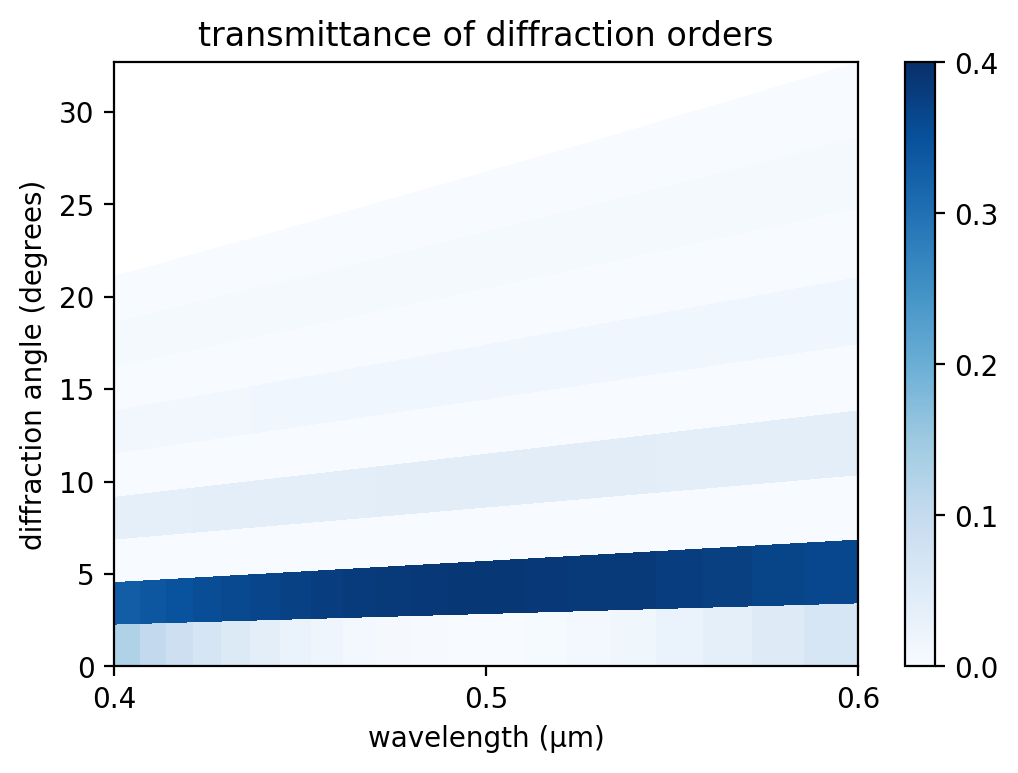

In [8]:
plt.figure(dpi=200)
plt.pcolormesh(
    np.reshape(mode_wvl, (nmode, nfreq)),
    np.reshape(mode_angle, (nmode, nfreq)),
    np.reshape(mode_tran, (nmode, nfreq)),
    cmap="Blues",
    shading="flat",
    vmin=0,
    vmax=tran_max,
)
plt.axis([min(mode_wvl), max(mode_wvl), min(mode_angle), max(mode_angle)])
plt.xlabel("wavelength (μm)")
plt.ylabel("diffraction angle (degrees)")
plt.xticks([t for t in np.linspace(wvl_min, wvl_max, 3)])
plt.yticks([t for t in range(0, 35, 5)])
plt.title("transmittance of diffraction orders")
cbar = plt.colorbar()
cbar.set_ticks([t for t in np.arange(0, tran_max + 0.1, 0.1)])
cbar.set_ticklabels(["{:.1f}".format(t) for t in np.arange(0, tran_max + 0.1, 0.1)])

Each diffraction order corresponds to a single angle. In the figure, this angle is represented by the *lower* boundary of each labeled region. For example, the $m$=0 order has a diffraction angle of 0° at all wavelengths. The representation of the diffraction orders as finite angular regions is an artifact of matplotlib's [pcolormesh](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.pcolormesh.html) routine. Note that only the positive diffraction orders are shown as these are equivalent to the negative orders due to the symmetry of the source and the structure. The transmittance of each diffraction order should ideally be a constant for all wavelengths. The slight wavelength dependence shown in the figure is due to numerical discretization which can be mitigated by increasing the resolution.

The diffraction orders/modes are a finite set of propagating planewaves. The wavevector $k_x$ of these modes can be computed analytically: for a frequency of $ω$ (in $c$=1 units), these propagating modes are the **real** solutions of sqrt(ω²n²-($k_y$+2π$m$/$Λ$)²) where $m$ is the diffraction order (an integer), $Λ$ is the periodicity of the grating, and $n$ is the refractive index of the propagating medium. In this example, $n$=1, $k_y$=0, and $Λ$=10 μm. Thus, at a wavelength of 0.5 μm there are a total of 20 diffraction orders of which we only computed the first 10. The wavevector $k_x$ is used to compute the angle of the diffraction order as cos<sup>-1</sup>($k_x$/($ωn$)). Evanescent modes, those with an imaginary k<sub>x</sub>, exist for |$m$|>20 but these modes carry no power. Note that currently Meep does not compute the number of propagating modes for you. If the mode number passed to `get_eigenmode_coefficients` is larger than the number of propagating modes at a given frequency/wavelength, MPB's Newton solver will fail to converge and will return zero for the mode\ coefficient. It is therefore a good idea to know beforehand the number of propagating modes.

In the limit where the grating periodicity is much larger than the wavelength and the size of the diffracting element (i.e., more than 10 times), as it is in this example, the [diffraction efficiency](https://en.wikipedia.org/wiki/Diffraction_efficiency) can be computed analytically using scalar theory. This is described in the OpenCourseWare [Optics course](https://ocw.mit.edu/courses/mechanical-engineering/2-71-optics-spring-2009/) in the Lecture 16 (Gratings: Amplitude and Phase, Sinusoidal and Binary) [notes](https://ocw.mit.edu/courses/mechanical-engineering/2-71-optics-spring-2009/video-lectures/lecture-16-gratings-amplitude-and-phase-sinusoidal-and-binary/MIT2_71S09_lec16.pdf) and [video](https://www.youtube.com/watch?v=JmWguqCZRxk). For a review of scalar diffraction theory, see Chapter 3 ("Analysis of Two-Dimensional Signals and Systems") of [Introduction to Fourier Optics (fourth edition)](https://www.amazon.com/Introduction-Fourier-Optics-Joseph-Goodman-ebook/dp/B076TBP48F) by J.W. Goodman. From the scalar theory, the diffraction efficiency of the binary grating is 4/(mπ)<sup>2</sup> when the phase difference between the propagating distance in the glass relative to the same distance in air is π. The phase difference/contrast is (2π/λ)(n-1)s where λ is the wavelength, n is the refractive index of the grating, and s is the propagation distance in the grating (`gh` in the script). A special feature of the binary grating is that the diffraction efficiency is 0 for all *even* orders. This is verified by the diffraction spectrum shown above. Also, since the diffraction efficiency of the ninth order has already fallen to a negligible value (~0.005), computing the spectra of higher-order modes is unnecessary.

To convert the diffraction efficiency into transmittance in the $x$ direction (in order to be able to compare the scalar-theory results with those from Meep), the diffraction efficiency must be multiplied by the Fresnel transmittance from air to glass and by the cosine of the diffraction angle. We compare the analytic and simulated results at a wavelength of 0.5 μm for diffraction orders 1 (2.9°), 3 (8.6°), 5 (14.5°), and 7 (20.5°). The analytic results are 0.3886, 0.0427, 0.0151, and 0.0074. The Meep results are 0.3891, 0.04287, 0.0152, and 0.0076. This corresponds to relative errors of approximately 1.3%, 0.4%, 0.8%, and 2.1% which indicates good agreement.

Finally, by investigating the transmittance of the zeroth order (at a wavelength of 0.5 μm) in the limit as the grating periodicity approaches zero, we can demonstrate the breakdown of the scalar theory in the wavelength-scale regime which can only be solved using a full-wave method. When the periodicity is much less than the wavelength (i.e., subwavelength), the transmittance can again be solved analytically using effective-medium theory involving a three-layer structure: a layer of the averaged ε (mean or harmonic mean depending on the polarization $E_z$ or $H_z$) sandwiched between the glass substrate and air. Results are shown in the following figure.

![](https://meep.readthedocs.io/en/latest/images/grating_0th_order_tran.png)

Starting around a grating periodicity of 1.0 μm, the transmittance is no longer zero and increases rapidly with decreasing periodicity. As shown in the inset, for periodicities less than 0.5 μm, the transmittance converges to its asymptotic limit determined by the effective-medium theory: 0.99744 for the $E_z$ and 0.99057 for the $H_z$ polarization. The weak polarization dependence is due to the low index contrast. The oscillations in the data are real and *not* an artifact of the discretization.

Now let's try using a dispersive medium instead of an ideal, constant refractive index:

-----------
Initializing structure...
field decay(t = 50.01): 0.11139427530016409 / 0.11139427530016409 = 1.0
field decay(t = 100.01): 1.824305440068526e-15 / 0.11139427530016409 = 1.637701250941967e-14
run 0 finished at t = 100.01 (10001 timesteps)
-----------
Initializing structure...
     block, center = (-2.25,0,0)
          size (4,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0,0)
          size (0.5,5,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
field decay(t = 50.01): 0.1082498119209954 / 0.1082498119209954 = 1.0
field decay(t = 100.01): 7.512926070352665e-06 / 0.1082498119209954 = 6.940359467632024e-05
field decay(t = 150.02): 6.732414916367269e-06 / 0.1082498119209954 = 6.219331744687766e-05
field decay(t = 200.03): 2.3712635292765586e-06 / 0.1082498119209954 = 2.1905474819736332e-05
field decay(t = 250.04): 9.494875348809632e-07 / 0.1082498119209954 = 8.771262675023706e-06
field decay(t = 300.04): 3.8220269083178343e-07 / 0.1082498119209954

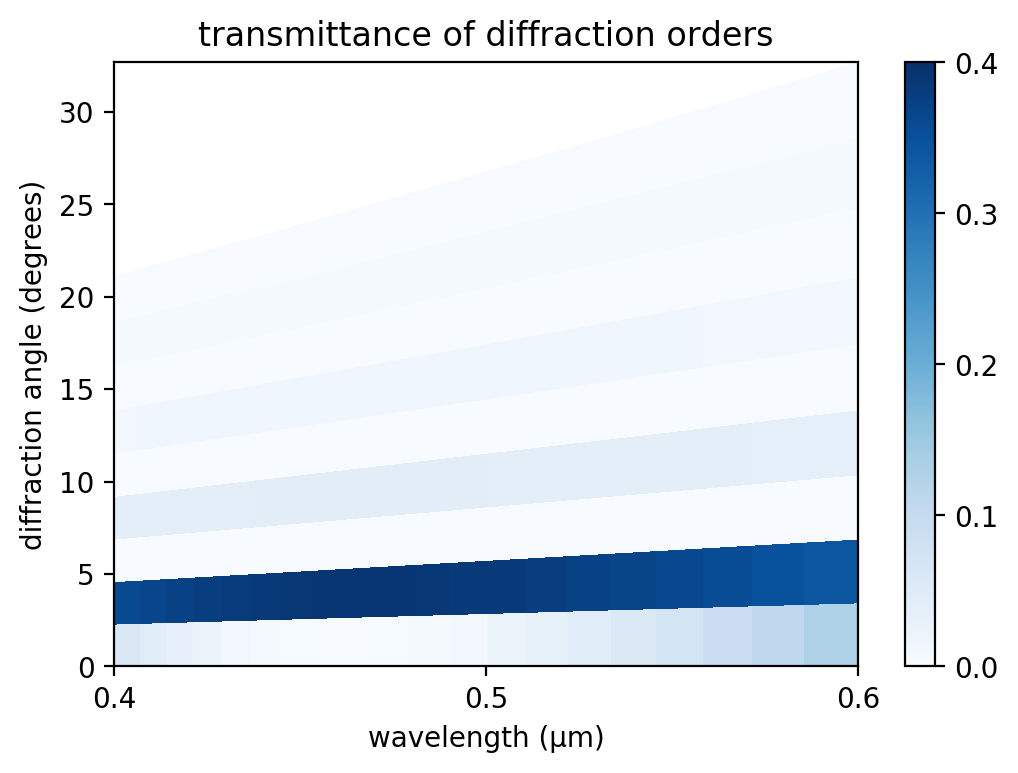

In [9]:
from meep.materials import fused_quartz

resolution = 50  # pixels/μm

dpml = 1.0  # PML thickness
dsub = 3.0  # substrate thickness
dpad = 3.0  # padding between grating and PML
gp = 10.0  # grating period
gh = 0.5  # grating height
gdc = 0.5  # grating duty cycle

sx = dpml + dsub + gh + dpad + dpml
sy = gp

cell_size = mp.Vector3(sx, sy, 0)
pml_layers = [mp.PML(thickness=dpml, direction=mp.X)]

wvl_min = 0.4  # min wavelength
wvl_max = 0.6  # max wavelength
fmin = 1 / wvl_max  # min frequency
fmax = 1 / wvl_min  # max frequency
fcen = 0.5 * (fmin + fmax)  # center frequency
df = fmax - fmin  # frequency width

src_pt = mp.Vector3(-0.5 * sx + dpml + 0.5 * dsub)
sources = [
    mp.Source(
        mp.GaussianSource(fcen, fwidth=df),
        component=mp.Ez,
        center=src_pt,
        size=mp.Vector3(y=sy),
    )
]

k_point = mp.Vector3(0, 0, 0)

symmetries = [mp.Mirror(mp.Y)]

sim = mp.Simulation(
    resolution=resolution,
    cell_size=cell_size,
    boundary_layers=pml_layers,
    k_point=k_point,
    default_material=fused_quartz,
    sources=sources,
    symmetries=symmetries,
)

nfreq = 21
mon_pt = mp.Vector3(0.5 * sx - dpml - 0.5 * dpad)
flux_mon = sim.add_flux(
    fcen, df, nfreq, mp.FluxRegion(center=mon_pt, size=mp.Vector3(y=sy))
)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mon_pt, 1e-9))

input_flux = mp.get_fluxes(flux_mon)

sim.reset_meep()

geometry = [
    mp.Block(
        material=fused_quartz,
        size=mp.Vector3(dpml + dsub, mp.inf, mp.inf),
        center=mp.Vector3(-0.5 * sx + 0.5 * (dpml + dsub)),
    ),
    mp.Block(
        material=fused_quartz,
        size=mp.Vector3(gh, gdc * gp, mp.inf),
        center=mp.Vector3(-0.5 * sx + dpml + dsub + 0.5 * gh),
    ),
]

sim = mp.Simulation(
    resolution=resolution,
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    k_point=k_point,
    sources=sources,
    symmetries=symmetries,
)

mode_mon = sim.add_flux(
    fcen, df, nfreq, mp.FluxRegion(center=mon_pt, size=mp.Vector3(y=sy))
)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, mon_pt, 1e-9))

freqs = mp.get_eigenmode_freqs(mode_mon)

nmode = 10
res = sim.get_eigenmode_coefficients(
    mode_mon, range(1, nmode + 1), eig_parity=mp.ODD_Z + mp.EVEN_Y
)
coeffs = res.alpha
kdom = res.kdom

mode_wvl = []
mode_angle = []
mode_tran = []

for nm in range(nmode):
    for nf in range(nfreq):
        mode_wvl.append(1 / freqs[nf])
        mode_angle.append(math.degrees(math.acos(kdom[nm * nfreq + nf].x / freqs[nf])))
        tran = abs(coeffs[nm, nf, 0]) ** 2 / input_flux[nf]
        mode_tran.append(0.5 * tran if nm != 0 else tran)

tran_max = round(max(mode_tran), 1)

plt.figure(dpi=200)
plt.pcolormesh(
    np.reshape(mode_wvl, (nmode, nfreq)),
    np.reshape(mode_angle, (nmode, nfreq)),
    np.reshape(mode_tran, (nmode, nfreq)),
    cmap="Blues",
    shading="flat",
    vmin=0,
    vmax=tran_max,
)
plt.axis([min(mode_wvl), max(mode_wvl), min(mode_angle), max(mode_angle)])
plt.xlabel("wavelength (μm)")
plt.ylabel("diffraction angle (degrees)")
plt.xticks([t for t in np.linspace(wvl_min, wvl_max, 3)])
plt.yticks([t for t in range(0, 35, 5)])
plt.title("transmittance of diffraction orders")
cbar = plt.colorbar()
cbar.set_ticks([t for t in np.arange(0, tran_max + 0.1, 0.1)])
cbar.set_ticklabels(["{:.1f}".format(t) for t in np.arange(0, tran_max + 0.1, 0.1)])

Since fuzed quartz isn't highly dispersive in this range, we don't see much of a difference between the two plots.